In [44]:
from rmp import RMPRoot
from rmp_leaf import NaiveCollisionAvoidance, CollisionAvoidance, GoalAttractorUni, Damper
import numpy as np
from numpy.linalg import norm
import platform
from scipy.integrate import solve_ivp as ode
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline
from matplotlib import animation, rc
from matplotlib import animation, rc
from IPython.display import HTML

In [45]:
class obstacle:
    def __init__(self, c, r=1):
        self.r = r
        self.c = c.reshape(-1,1)

class scene:
    def __init__(self, goal=None, obstacle=None, x=None, x_dot=None):
        self.goal = goal
        self.obstacle = obstacle
        if goal is not None:
            goal.reshape(-1, 1)
            self.dim = goal.size
        if obstacle is not None:
            self.num_obs = len(obstacle)
            [obs.c.reshape(-1,1) for obs in obstacle]
            self.dim = obstacle[0].c.size
        if x is None:
            x = np.zeros(dim)
        if x_dot is None:
            x_dot = np.zeros(dim)
        self.init_state = np.concatenate((x, x_dot), axis=None)

    def set_init_state(x, x_dot):
        self.init_state = np.concatenate((x, x_dot), axis=None)
    
    
class policy_evaluator:
    def __init__(self, scene, r, leafs, tspan):
        self.scene = scene
        self.r = r
        self.tspan = tspan
        [r.add_child(leaf) for leaf in leafs]
        #self.sol = ode(self.dynamics, self.tspan, self.scene.init_state)
        self.sol = odeint(self.dynamics, self.scene.init_state, self.tspan)               
    
    def dynamics(self, state, t):
        state = state.reshape(2, -1)
        x = state[0]
        x_dot = state[1]
        x_ddot = self.r.solve(x, x_dot)
        state_dot = np.concatenate((x_dot, x_ddot), axis=None)
        return state_dot
    
    def step_cost(self):
        for i in range(self.sol.shape[0]):
            if( norm(self.sol[i][:2] - self.scene.goal) < 1e-2):
                #print('step cost: {0}'.format(i))
                return self.tspan[i]
        print('task failed, goal has not achieved')
        return None
        
    def plot(self):
        if self.scene.dim != 2:
            return
        plt.plot(self.sol[:, 0], self.sol[:, 1])
        if self.scene.goal is not None:
            plt.plot(self.scene.goal[0], self.scene.goal[1], 'go')
        for obs in self.scene.obstacle:
            circle = plt.Circle((obs.c[0], obs.c[1]), obs.r, color='k', fill=False)
            plt.gca().add_artist(circle)
        plt.axis([-5, 5, -5, 5])
        plt.gca().set_aspect('equal', 'box')
        plt.show()
    
    def video(self):
        fig, ax = plt.subplots()
        x, y = [], []
        ln, = plt.plot([], [], 'ro')
        def init():
            ax.set_xlim(-5, 5)
            ax.set_ylim(-5, 5)
            return ln,
        def update(i):
            x.append(self.sol.y[0][i])
            y.append(self.sol.y[1][i])
            ln.set_data(x, y)
            return ln,
        ani = animation.FuncAnimation(fig, update, frames=50, init_func=init, blit=True)
        HTML(ani.to_html5_video())
# --------------------------------------------

In [54]:
x_g = np.array([-1, 2.6])
x_o = np.array([0, 0])
x_o2 = np.array([0, 2])
x = np.array([2.5, -3.2])
x_dot = np.array([-1, 2])

test_scene = scene(goal=x_g, obstacle=[obstacle(x_o, 0.5)], x=x, x_dot=x_dot)

r = RMPRoot('Root')
leaf1 = CollisionAvoidance('collision_avoidance', r, None, 
                           epsilon=0.2, alpha=0.01, c=test_scene.obstacle[0].c, 
                           R=test_scene.obstacle[0].r)

#leaf1_ = CollisionAvoidance('collision_avoidance', r, None, epsilon=0.2, alpha=0.01, c=test_scene.obstacle[1].c, R=test_scene.obstacle[1].r)
leaf2 = GoalAttractorUni('goal_attractor', r, test_scene.goal)

leaf3 = NaiveCollisionAvoidance('naive',r, None, alpha=0.01, c=test_scene.obstacle[0].c,
                               R=test_scene.obstacle[0].r)
damper = Damper('damper', r)


#leaf3_ = NaiveCollisionAvoidance('naive',r, None, alpha=0.01, c=test_scene.obstacle[1].c, R=test_scene.obstacle[1].r)
pe = policy_evaluator(test_scene, r, [damper, leaf2, leaf3], np.linspace(0, 30, 300))

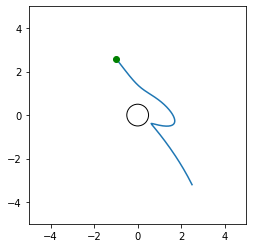

step cost 21.17056856187291


In [55]:
pe.plot()
print('step cost', pe.step_cost())

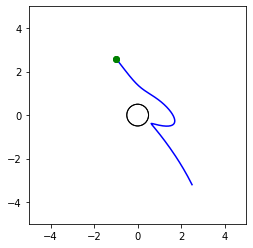

In [56]:
sol = pe.sol
fig, ax = plt.subplots()
x, y = [], []
ln, = plt.plot([], [], 'b-')

def init():
    if test_scene.goal is not None:
        plt.plot(test_scene.goal[0], test_scene.goal[1], 'go')
    for obs in test_scene.obstacle:
        circle = plt.Circle((obs.c[0], obs.c[1]), obs.r, color='k', fill=False)        
        plt.gca().add_artist(circle)
    ax.set_xlim([-5,5])
    ax.set_ylim([-5,5])
    plt.gca().set_aspect('equal', 'box')
    return ln,
def update(i):
    x.append(sol[:, 0][i])
    y.append(sol[:, 1][i])
    ln.set_data(x, y)
    return ln,
ani = animation.FuncAnimation(fig, update, frames=300, interval=30, init_func=init, blit=True)
HTML(ani.to_html5_video())